In [1]:
#!/usr/bin/env python
# coding: utf-8
from tqdm  import tqdm 
from tqdm import trange
from pyDOE import lhs
import torch
torch.cuda.empty_cache()

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
warnings.filterwarnings('ignore')



import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False   # 设置显示负号
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12  # 可调整字体大小，例如 12
np.random.seed(2023)
# 检查是否有可用的GPU设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


MESH

In [2]:
import re
import matplotlib.pyplot as plt
import numpy as np

import re

def extract_mesh_from_inp(file_path):
    """
    从 Abaqus .inp 文件中提取节点和 CPE4RP 元素信息，转换节点索引为 0-based。
    
    参数：
        file_path: .inp 文件路径。
    
    返回：
        nodes: list of (node_id, x, y)，节点 ID (0-based) 和坐标（仅 x, y）。
        elements: list of [node_id1, node_id2, node_id3, node_id4]，单元的节点索引 (0-based)。
        node_sets: dict，节点集。
        element_type: str，单元类型（如 'CPE4RP'）。
    """
    nodes = []
    elements = []
    node_sets = {}
    element_type = None

    with open(file_path, 'r') as f:
        reading_nodes = False
        reading_elements = False
        reading_nsets = False
        current_nset = None

        for line in f:
            line = line.strip()
            if line.startswith("*Node"):
                reading_nodes = True
                reading_elements = False
                reading_nsets = False
                continue
            elif line.startswith("*Element"):
                reading_nodes = False
                reading_elements = True
                reading_nsets = False
                element_type_match = re.search(r"type=(\w+)", line)
                element_type = element_type_match.group(1) if element_type_match else None
                continue
            elif line.startswith("*Nset"):
                reading_nodes = False
                reading_elements = False
                reading_nsets = True
                current_nset = line.split('=')[-1].strip()
                node_sets[current_nset] = []
                continue
            elif line.startswith("*End") or line.startswith("*Elset"):
                reading_nodes = False
                reading_elements = False
                reading_nsets = False
                continue
            if reading_nodes:
                node_data = re.split(r',\s*', line.strip())
                if len(node_data) >= 3:  # CPE4RP 只需 x, y 坐标
                    try:
                        node_id = int(node_data[0]) - 1  # 转换为 0-based
                        x, y = map(float, node_data[1:3])  # 只取 x, y
                        nodes.append((node_id, x, y))
                    except ValueError:
                        continue
            if reading_elements:
                element_data = re.split(r',\s*', line.strip())
                if len(element_data) >= 5:  # CPE4RP: 1 element_id + 4 node_ids
                    try:
                        element_nodes = [int(n) - 1 for n in element_data[1:5]]  # 转换为 0-based
                        if element_type == "CPE4RP" and len(element_nodes) == 4:
                            elements.append(element_nodes)
                        else:
                            print(f"警告: 单元 {element_data[0]} 被跳过，无效节点数或类型")
                    except ValueError:
                        print(f"警告: 行数据无效: {line}")
                        continue
            if reading_nsets:
                if "generate" in line.lower():
                    node_ids = re.split(r',\s*', line.strip())
                    if len(node_ids) >= 3:
                        try:
                            start, end, step = map(int, node_ids[:3])
                            node_sets[current_nset].extend([n - 1 for n in range(start, end + 1, step)])
                        except ValueError:
                            continue
                else:
                    node_ids = re.split(r',\s*', line.strip())
                    if all(nid.strip().isdigit() for nid in node_ids if nid.strip()):
                        node_sets[current_nset].extend([int(nid) - 1 for nid in node_ids if nid.strip()])

    # 检查节点索引有效性
    max_node_id = max([n[0] for n in nodes]) if nodes else -1
    for e, elem in enumerate(elements):
        for nid in elem:
            if nid < 0 or nid > max_node_id:
                print(f"错误: 单元 {e+1} 包含无效节点索引 {nid + 1} (0-based: {nid})")
                return [], [], {}, None

    return nodes, elements, node_sets, element_type

import numpy as np
import matplotlib.pyplot as plt

def plot_2d_mesh(nodes, elements):
    """
    绘制 CPE4RP 网格的二维线框可视化，跳过无效四边形。
    
    参数：
        nodes: 节点列表 [(node_id, x, y), ...]
        elements: 元素列表 [[node_id1, node_id2, node_id3, node_id4], ...]
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)

    # 提取节点坐标
    nodes_array = np.array([n[1:3] for n in nodes])  # (num_nodes, 2)
    invalid_elements = 0

    # 绘制四边形元素
    for e, node_ids in enumerate(elements):
        # 获取四边形四个节点的坐标
        coords = nodes_array[node_ids]  # (4, 2)
        if len(set(node_ids)) != 4:
            print(f"警告: 单元 {e} 存在重复节点: {node_ids}")
            invalid_elements += 1
            continue

        x = coords[:, 0]
        y = coords[:, 1]

        # 检查四边形面积（使用 Shoelace 公式）
        area = 0.5 * abs(
            (x[0] * y[1] + x[1] * y[2] + x[2] * y[3] + x[3] * y[0])
            - (y[0] * x[1] + y[1] * x[2] + y[2] * x[3] + y[3] * x[0])
        )
        if area < 1e-10:
            print(f"警告: 单元 {e} 面积接近零 {area}，跳过")
            invalid_elements += 1
            continue

        # 闭合四边形
        x = list(x) + [x[0]]
        y = list(y) + [y[0]]
        ax.plot(x, y, 'b-', alpha=0.5)

    print(f"总计跳过无效单元数: {invalid_elements}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.title('2D Quadrilateral Mesh (CPE4RP)')
    plt.grid(True)
    plt.axis('equal')  # 确保比例相等以正确显示几何形状
    plt.show()


单线段的R函数距离

In [3]:
def dist(x1, y1, x2, y2):
    """计算两点间距离"""
    return torch.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def linseg(x, y, x1, y1, x2, y2):
    """单线段的R函数距离，防止零值"""
    eps=1e-20
    L = dist(x1, y1, x2, y2)
    L = torch.where(L > eps, L, eps)  # 防止除零
    xc = (x1 + x2) / 2.0
    yc = (y1 + y2) / 2.0
    f = (1.0 / L) * ((x - x1) * (y2 - y1) - (y - y1) * (x2 - x1))
    t = (1.0 / L) * ((L / 2.0)**2 - dist(x, y, xc, yc)**2)
    varphi = torch.sqrt(t**2 + f**4 + eps)
    phi_i = torch.sqrt(f**2 + (1.0 / 4.0) * (varphi - t)**2 + eps)
    return phi_i

def phi(x, y, segments, m=1.0):
    """多边形R函数距离，基于边集合"""
    R = torch.zeros_like(x)
    for i in range(len(segments)):
        # 直接从segments中提取每条边的起点和终点
        x1, y1 = segments[i, 0]  # 第一顶点 [x1, y1]
        x2, y2 = segments[i, 1]  # 第二顶点 [x2, y2]
        phi_i = linseg(x, y, x1, y1, x2, y2)
        R += 1.0 / phi_i**m
    return 1.0 / R**(1.0 / m)

定义非同质边界条件 g(x)

In [4]:
def boundary_g(x, y, segments, bc_values):
    """超限插值构造 g(x, y)，基于边集合"""
    mu = 1.0
    weights = []
    for i in range(len(segments)):
        x1, y1 = segments[i, 0]
        x2, y2 = segments[i, 1]
        phi_i = linseg(x, y, x1, y1, x2, y2)
        weights.append(phi_i**(-mu))

    
    weights = torch.stack(weights)

    g_values = torch.tensor(bc_values, dtype=torch.float32, device=x.device)

    w = weights / torch.sum(weights, dim=0)
    g = torch.sum(w * g_values.view(-1, 1, 1), dim=0)
   
    return g

绘制距离函数云图

In [5]:
def plot_phi(bc,n_grid=100):
    x = torch.linspace(-1, 3.5, n_grid)
    y = torch.linspace(-1, 3.0, n_grid)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    X_flat, Y_flat = X.reshape(-1), Y.reshape(-1)
    
    phi_vals = phi(X_flat, Y_flat, bc).reshape(n_grid, n_grid).cpu().detach().numpy()
    
    plt.figure(figsize=(8, 6))
    plt.contourf(X.cpu(), Y.cpu(), phi_vals, levels=20, cmap='viridis')
    plt.colorbar(label='Distance Function φ(x, y)')
    

    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

shape function

In [6]:
import numpy as np
import torch

def compute_shape_functions(nodes, elements, device='cpu'):
    num_elements = elements.shape[0]
    num_nodes = nodes.shape[0]
    gauss_points = []
    shape_vals = np.zeros((num_elements, num_nodes))  # CPE4RP 有 4 个节点
    shape_grads = np.zeros((num_elements, num_nodes, 2))
    areas = np.zeros(num_elements)
    negative_grad_count = 0
    total_grad_count = 0

    for e, elem in enumerate(elements):
        # 获取四边形四个节点的坐标
        x1, y1 = nodes[elem[0]]
        x2, y2 = nodes[elem[1]]
        x3, y3 = nodes[elem[2]]
        x4, y4 = nodes[elem[3]]

        # 计算面积（使用 Shoelace 公式）
        A = 0.5 * abs(
            (x1 * y2 + x2 * y3 + x3 * y4 + x4 * y1) -
            (y1 * x2 + y2 * x3 + y3 * x4 + y4 * x1)
        )
        if A < 1e-10:
            print(f"警告: 单元 {e} 面积接近零: {A}")
            A = 1e-10
        areas[e] = A

        # 计算形心（高斯积分点）
        x_g = (x1 + x2 + x3 + x4) / 4
        y_g = (y1 + y2 + y3 + y4) / 4
        gauss_points.append([x_g, y_g])

        # CPE4RP 单点积分形函数（形心处，局部坐标 (xi, eta) = (0, 0)）
        N1 = 0.25 * (1 - 0) * (1 - 0)  # N1 = 0.25 * (1 - xi) * (1 - eta)
        N2 = 0.25 * (1 + 0) * (1 - 0)  # N2 = 0.25 * (1 + xi) * (1 - eta)
        N3 = 0.25 * (1 + 0) * (1 + 0)  # N3 = 0.25 * (1 + xi) * (1 + eta)
        N4 = 0.25 * (1 - 0) * (1 + 0)  # N4 = 0.25 * (1 - xi) * (1 + eta)
        N_total = N1 + N2 + N3 + N4
        expected = 0.25  # 形心处每个形函数值为 0.25

        # 检查形函数和
        if abs(N_total - 1.0) > 1e-6 or min(N1, N2, N3, N4) < -1e-6:
            print(f"单元 {e}: 形函数和={N_total}, N1={N1}, N2={N2}, N3={N3}, N4={N4}")
        elif abs(N1 - expected) > 1e-6 or abs(N2 - expected) > 1e-6 or abs(N3 - expected) > 1e-6 or abs(N4 - expected) > 1e-6:
            print(f"单元 {e}: 形函数值异常, N1={N1}, N2={N2}, N3={N3}, N4={N4}")

        shape_vals[e, elem[0]] = N1
        shape_vals[e, elem[1]] = N2
        shape_vals[e, elem[2]] = N3
        shape_vals[e, elem[3]] = N4

        # 计算雅可比矩阵
        dN_dxi = np.array([
            [-0.25 * (1 - 0), 0.25 * (1 - 0), 0.25 * (1 + 0), -0.25 * (1 + 0)],  # dN/dxi
            [-0.25 * (1 - 0), -0.25 * (1 + 0), 0.25 * (1 + 0), 0.25 * (1 - 0)]   # dN/deta
        ])
        coords = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
        J = np.dot(dN_dxi, coords)  # 雅可比矩阵 (2x2)

        # 检查雅可比行列式
        det_J = np.linalg.det(J)
        if det_J < 1e-10:
            print(f"警告: 单元 {e} 雅可比行列式接近零: {det_J}")
            det_J = 1e-10

        # 计算形函数导数（全局坐标）
        J_inv = np.linalg.inv(J)
        dN_dxi_global = np.dot(J_inv, dN_dxi)  # dN/dx = J_inv * dN/dxi
        dN_dx = dN_dxi_global[0, :]
        dN_dy = dN_dxi_global[1, :]

        # 统计负导数值
        for grad in dN_dx:
            total_grad_count += 1
            if grad < 0:
                negative_grad_count += 1
        for grad in dN_dy:
            total_grad_count += 1
            if grad < 0:
                negative_grad_count += 1

        # 检查导数和
        dx_sum = dN_dx.sum()
        dy_sum = dN_dy.sum()
        if abs(dx_sum) > 1e-6 or abs(dy_sum) > 1e-6:
            print(f"单元 {e}: dN_dx 和={dx_sum}, dN_dy 和={dy_sum}, dN_dx={dN_dx}, dN_dy={dN_dy}")

        shape_grads[e, elem[0], :] = [dN_dx[0], dN_dy[0]]
        shape_grads[e, elem[1], :] = [dN_dx[1], dN_dy[1]]
        shape_grads[e, elem[2], :] = [dN_dx[2], dN_dy[2]]
        shape_grads[e, elem[3], :] = [dN_dx[3], dN_dy[3]]

    print("面积范围:", areas.min(), areas.max())
    print(f"负导数值: {negative_grad_count}/{total_grad_count} ({negative_grad_count/total_grad_count*100:.2f}%)")
    return (
        np.array(gauss_points),
        torch.tensor(shape_vals, dtype=torch.float32, device=device),
        torch.tensor(shape_grads, dtype=torch.float32, device=device),
        torch.tensor(areas, dtype=torch.float32, device=device)
    )


#########  PINN  ######### 

In [7]:
# 均方误差 MSE
mse_loss = torch.nn.MSELoss() 

# 定义 MAE 损失(绝对误差)
mae_loss = nn.L1Loss()

In [8]:
import time
from torch.optim import lr_scheduler
from scipy.spatial import Delaunay
from scipy.spatial import Voronoi, voronoi_plot_2d
import torch.nn.init as init
class PINNs():
    def __init__(
        self, 
        activation, 
        device,
        initial_lr, sadap,
        K,
        faces,bc,
        gp,  gp_shape, gp_shape_grad, areas,
        mesh_nodes,
        loss_threshold
    ):

        self.device = device
        # self.t_point = t_point
        ###  材料参数  ###


        self.iter_res=0
        self.iter_phi=0

           
        self.train_losses = []
        self.train_losses_phi = []
        self.end_time = []
        self.faces = faces
        self.bc = bc

        self.K_ = torch.tensor(K, dtype=torch.float32, device=device)
        self.k = self.K_/9.81/1.0




        self.gp = torch.tensor(gp, dtype=torch.float32, device=device)
        self.gp_shape = torch.tensor(gp_shape, dtype=torch.float32, device=device)
        self.gp_shape_grad_x = torch.tensor(gp_shape_grad[:, :, 0], dtype=torch.float32, device=device)
        self.gp_shape_grad_y = torch.tensor(gp_shape_grad[:, :, 1], dtype=torch.float32, device=device)

        self.areas = torch.tensor(areas, dtype=torch.float32, device=device)

        beta_init = 0.0  # 初始值
        ##u

        self.gp_x = self.gp[:, 0].reshape(-1, 1)  # [N, 1]  
        self.gp_y = self.gp[:, 1].reshape(-1, 1)


        self.mesh_nodes = torch.tensor(mesh_nodes, dtype=torch.float32, device=device)
        self.mesh_nodes_x = self.mesh_nodes[:, 0].reshape(-1, 1)  # [N, 1]
        self.mesh_nodes_y = self.mesh_nodes[:, 1].reshape(-1, 1)
        

        ####
        self.beta_u = torch.full(self.mesh_nodes_x.shape, beta_init, requires_grad=True, device=device)  #
        # self.beta_u = torch.empty(self.mesh_nodes_x.shape, requires_grad=True, device=device)

        # 应用 Xavier 均匀分布初始化
        init.xavier_uniform_(self.beta_u)

        xx =  (torch.tensor(mesh_nodes).float().to(device))[:, 0].reshape(-1, 1) 
        yy =  (torch.tensor(mesh_nodes).float().to(device))[:, 1].reshape(-1, 1) 
        ##u



        ##v

        self.phi_val = phi(xx, yy, self.faces)
        self.g_val = boundary_g(xx, yy, self.faces, self.bc)


        ############################################


        # 优化器：使用相同的设置
        self.optimizer_res = torch.optim.LBFGS(
            [self.beta_u], 
            lr=initial_lr, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change = 1e-5 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # 使用强沃尔夫线搜索条件
        )


     
        self.sadap_res=sadap #自适应学习率（是否）  每次更新时将学习率乘以 0.9（即每 1000 次迭代后，学习率减小到 90%）


        self.optimizer_Adam_res = torch.optim.Adam(params=[self.beta_u], lr=initial_lr)


        if self.sadap_res:
            self.scheduler_res = lr_scheduler.StepLR(self.optimizer_Adam_res, step_size=1000, gamma=0.9)

     # def optim_Adam(self,model):
    #     opt_adam = torch.optim.Adam(params=model.parameters(), lr=self.initial_lr)
    #     return opt_adam
    def xavier_init(self,layer):
        """
        对神经网络层进行 Xavier 初始化，包括权重和偏置
        
        Parameters:
            - layer (torch.nn.Module): 神经网络层
            
        Notes:
            该函数用于初始化线性层（nn.Linear），使用 Xavier 初始化方法，即将权重初始化为均匀分布，
            将偏置初始化为零。
        """
        if isinstance(layer, nn.Linear):  # 检查是否为线性层
            nn.init.xavier_uniform_(layer.weight)  # 使用Xavier初始化方法初始化权重
            nn.init.zeros_(layer.bias)  # 将偏置初始化为零

    


    #########################
    #######         #########
    #######  train  #########
    #######         #########
    #########################
    def closure_res(self):

        loss = self.lossf_res(
            td=None,
        )

        # self.iter += 1
        # if self.iter % 100 == 0:
        #     print(f'Loss: {loss.item():.6f}')

        self.optimizer_res.zero_grad()
        loss.backward()

        return loss
    
    def train_res(self, epochs):
 
        #开启训练模式
        # model = self.uv_dnn
        # model.train()
        self.lossf_res = self.loss_res_all
        self.start_time = time.time()  # 记录迭代开始时间
        
        with trange(epochs, dynamic_ncols=True, ncols=1) as td:
            for epoch in td:


                loss = self.lossf_res(td=td, print_str="", loss_model=mse_loss)


                self.iter_res += 1

                # 反向传播和优化
                self.optimizer_Adam_res.zero_grad()
#                 if torch.isnan(loss).any():
#                     print("Loss contains NaN values. Check your model and input data.")
                loss.backward()
                self.optimizer_Adam_res.step()

                self.train_losses.append(loss)
                self.end_time.append(time.time())  # 记录时间
                if loss.item() < loss_threshold:
                    print(f"Stopping early at epoch {epoch} as loss {loss.item()} < {loss_threshold}")
                    break
                
                if self.sadap_res:
                    self.scheduler_res.step()
    
        # self.optimizer_res.step(closure=self.closure_res)


    #########################################
    def predict_res(self):
        # 模型 评估模式
        
        # 提取 u 和 v 分量
        # output = self.MLS_PINN(uv)  # [num_elements, 2]
        Ui = self.trial_function()#(1562,2)


        # 计算一阶导数
        u_x =  -self.k/9.81*self.gp_shape_grad_x @ Ui # [N, 1]
        u_y =  -self.k/9.81*self.gp_shape_grad_y @ Ui  # [N, 1]


        u = self.gp_shape @ Ui


        u = torch.tensor(u, dtype=torch.float32, requires_grad=True)
        output = torch.cat([u,  u_x, u_y], dim=1)
        return output

    
    def trial_function(self):
        """试探函数：u = g(x) + phi(x) * u_nn"""

      
        u = self.g_val + self.phi_val * self.beta_u

        return u   



    ####  能量函数   #### 线弹性
    def compute_energy(self):
        """
        计算总应变能
        参数：
            coords: 高斯积分点坐标，形状为 [num_elements, 2]
        返回：
            energy: 总能量（标量）
        """
    
        # 提取 u 和 v 分量
        # output = self.MLS_PINN(uv)  # [num_elements, 2]

        Ui = self.trial_function()#(1562,2)


        # 计算一阶导数
        u_x =  self.gp_shape_grad_x @ Ui # [N, 1]
        u_y =  self.gp_shape_grad_y @ Ui  # [N, 1]


        # 计算能量密度
        energy_density = 0.5 * self.k*((u_x)**2+(u_y)**2)  # [num_elements, 1]

        energy_density = energy_density.squeeze(-1)  # [num_elements]
        

        # 计算总能量
        energy = torch.sum(energy_density * self.areas)

        
        return energy
    
       
    def loss_RES(self, loss):
     
        energy = self.compute_energy()  # [num_elements, 1]
        star = torch.zeros_like(energy).reshape(-1, 1)

  
        loss_res = loss(energy, star)
        return loss_res       

    

#############################################    
#    
    def loss_res_all(self, td=None, print_str="", loss_model=mse_loss):
        loss_res = self.loss_RES(loss=loss_model)  
        loss_all = loss_res
        
        if td is not None:
            td.set_description(f"RES: {loss_res.item():.6f}, ALL: {loss_res.item():.6f}"+print_str)
        
        return loss_all    



成功提取网格信息：
节点数: 2828
元素数: 2637
节点集: ['Set-1, generate', 'Part-3-1']
元素类型: None


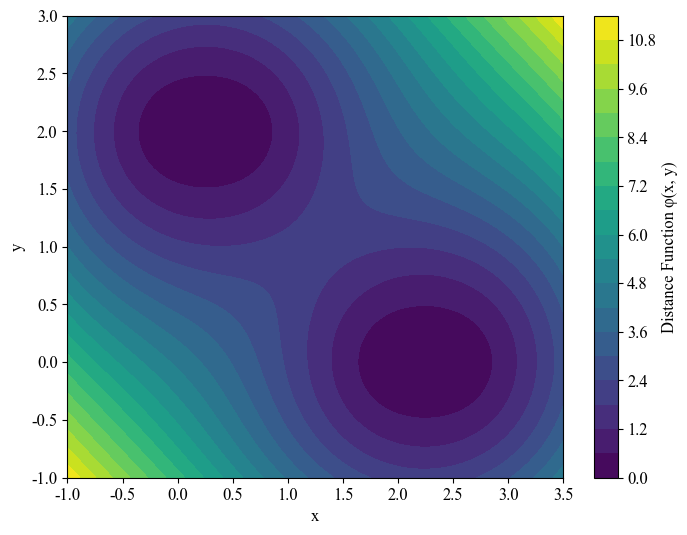

面积范围: 0.0004116241362606132 0.002359378501657572
负导数值: 10548/21096 (50.00%)


In [ ]:
loss_threshold = 16.10
# 指定 .inp 文件路径
# file_path_ = r"D:\Jupyter\CW_hidenn\inp\darcy\darcy.inp"  
# txt_path = r"D:\Jupyter\CW_hidenn\txt\darcy"
# path_mesh = r"D:\Jupyter\CW_hidenn\fig\darcy\mesh.jpg"
faces = torch.tensor([
[[0.0, 2.0],[0.5, 2.0]],
[[2.0, 0.0],[2.5, 0.0]]
])


bc_points = [
    (0.0, 0.0), (0.0, 2.0), (0.5, 2.0), (0.5, 0.5),
    (1.0, 0.5), (1.0, 2.0), (2.5, 2.0), (2.5, 0.0),
    (2.0, 0.0), (2.0, 1.5), (1.5, 1.5), (1.5, 0.0)
    
]
bc = [98.1,0.0]
nodes_, elements, node_sets, element_type = extract_mesh_from_inp(file_path_)
print(f"成功提取网格信息：")
print(f"节点数: {len(nodes_)}")
print(f"元素数: {len(elements)}")
print(f"节点集: {list(node_sets.keys())}")
print(f"元素类型: {element_type}")

plot_phi(faces,n_grid=100)



nodes = np.array([n[1:3] for n in nodes_])  # 提取 x, y, z
elements = np.array(elements)  # 直接使用节点索引



gp,gp_shape, gp_shape_grad, areas = compute_shape_functions(nodes, elements)

# plot_2d_mesh(nodes_, elements, gp, path_mesh, line_width=0.2, gp_color='red', gp_size=1)
##########

activation='tanh'
initial_lr=0.1
sadap = True

k=1
model = PINNs(
    activation, 
    device,
    initial_lr, sadap,
    k,
    faces,bc,
    gp,  gp_shape, gp_shape_grad, areas,
    nodes,
    loss_threshold

)

MAIN

In [10]:
model.train_res(epochs=15000)

RES: 1609.552734, ALL: 1609.552734:  25%|██▌       | 3799/15000 [00:05<00:15, 718.46it/s] 


KeyboardInterrupt: 